# Libraries

In [109]:
import pandas as pd
import re
import numpy as np
import pickle
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import seaborn as sns
from IPython.display import display, HTML
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense,Dropout ,LSTM,GRU, Input,GlobalMaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import warnings
warnings.filterwarnings('always')

# Loading Data

In [112]:
fake= pd.read_csv("Fake.csv")
true= pd.read_csv("True.csv")

In [113]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [114]:
fake.drop(columns=["title","date","subject"],inplace=True)
true.drop(columns=["title","date","subject"],inplace=True)

In [115]:
true['label'] = 0
fake['label'] = 1

In [116]:
print(f"Fake News : {fake.shape}")
print(f"Real News : {true.shape}")

Fake News : (23481, 2)
Real News : (21417, 2)


# Make Data Balanced

In [118]:
df_real = true.sample(21417, random_state=2000)
df_fake = fake.sample(21417, random_state=2000)

In [119]:
df = pd.concat([df_real, df_fake])

In [120]:
df =df.sample(frac=1, random_state=2000).reset_index(drop=True)

In [121]:
print(f"Balanced dataset shape : {df.shape}")

Balanced dataset shape : (42834, 2)


# Display Sample Of Data

In [128]:
def styled_heading(text, background_color='#4a90e2', text_color='white'):
    return f"""<p style="background-color: {background_color};
        font-family: Trebuchet MS, sans-serif;
        font-size: 130%;
        color: {text_color};
        text-align: center;
        border-radius: 8px;
        padding: 8px;
        font-weight: bold;
        box-shadow: 0px 2px 6px rgba(0, 0, 0, 0.25);
        width: fit-content;
        margin: 10px auto;">
        {text}
    </p>"""
def style_table(df, header_color='#4a90e2'):
    styled_df = df.style.set_table_styles([{"selector": "th", "props": [("color", "white"), ("background-color", header_color),("font-weight", "bold"), ("text-align", "center")]}
    ]).set_properties(**{"text-align": "center", "border": "1px solid #ddd", "padding": "5px"}) \
     .hide(axis="index")
    return styled_df.to_html()

def show_sample_and_counts(df, n_top=5, heading_color='#4a90e2', text_color='white'):
    sample_heading = styled_heading("Sample from Dataset", heading_color, text_color)
    display(HTML(sample_heading))
    display(HTML(style_table(df.head(n_top), header_color=heading_color)))

    counts_heading = styled_heading("Label Distribution", heading_color, text_color)
    display(HTML(counts_heading))
    counts_df = df['label'].value_counts().rename_axis('Label').reset_index(name='Count')
    display(HTML(style_table(counts_df, header_color=heading_color)))
def check_duplicates(df, heading_color='#4a90e2', text_color='white'):
    dup_heading = styled_heading(" Duplicate ", heading_color, text_color)
    display(HTML(dup_heading))

    dup_count = df.duplicated().sum()
    if dup_count > 0:
        dup_df = pd.DataFrame({"Duplicate Rows": [dup_count]})
        display(HTML(style_table(dup_df, header_color=heading_color)))
    else:
        display(HTML("<p style='text-align:center; color:green; font-weight:bold;'> No duplicate rows found.</p>"))


In [133]:
show_sample_and_counts(df,n_top=6,heading_color='#2c3e50', text_color='white')
check_duplicates(df, heading_color='#2c3e50', text_color='white')

text,label
"WASHINGTON (Reuters) - U.S. Senate Majority Leader Mitch McConnell on Wednesday dashed any remaining hopes that President Barack Obama’s signature Pacific-Rim trade deal would come up for a vote before President-elect Donald Trump takes office in January. “It’s certainly not going to be brought up this year,” McConnell said of the 12-country Trans-Pacific Partnership (TPP) at a news briefing in Washington. McConnell said any decisions on TPP or other future trade agreements would be up to Trump, who would still have the authority for four more years to negotiate “better deals” with expedited approval procedures in Congress. Trump excoriated TPP on the campaign trail as a “disaster” and “a rape of our country,” tapping into populist anger at globalization, trade and manufacturing job losses that helped propel his candidacy. In an opinion piece published on Monday, Trump advisers Peter Navarro and Alexander Gray reiterated his opposition to major trade deals. “Trump will never again sacrifice the U.S. economy on the altar of foreign policy by entering into bad trade deals like the North American Free Trade Agreement, allowing China into the World Trade Organization, and passing the proposed TPP,” Navarro and Gray wrote in Foreign Policy magazine. “These deals only weaken our manufacturing base and ability to defend ourselves and our allies.” The Obama administration has been promoting TPP among lawmakers and industry groups in anticipation of a long-shot, post-election vote despite opposition to the deal by Trump and his Democratic opponent, Hillary Clinton. While there are many Republican supporters of free trade and TPP in Congress, McConnell and House of Representatives Speaker Paul Ryan said on Wednesday they were now focused on laying the groundwork with Trump to pass Republican-focused healthcare and tax reform legislation next year. A spokeswoman for Ryan said he had not had a change of heart since he said on a radio talk show in October that the House would not bring TPP up for a vote because of problems with several provisions and insufficient support in the House. McConnell said his priorities for the post-election “lame-duck” session were passing a government funding extension and medical innovation legislation. White House spokesman Josh Earnest was still trying to sell the TPP agreement in a news briefing on Wednesday. “President Obama does continue to believe that this is the best opportunity that the Congress has to take advantage of the benefits of a Trans-Pacific Partnership agreement that cuts taxes, 18,000 taxes, that other countries impose on American products,” Earnest told reporters. “We’ve got a strong case to make.” But the strong vote for Trump in industrial states made it unlikely Republicans would be willing to go against him on trade policy, analysts said. “It’s fair to say that TPP is now in the dustbin of history,” said Gary Hufbauer, a senior fellow at the Peterson Institute for International Economics, a pro-trade think tank in Washington. “I don’t see a path forward for the United States to join.”",0
"CARACAS (Reuters) - Venezuela on Monday accused U.S. President Donald Trump of conducting political terrorism through travel restrictions on eight countries including the socialist-run South American nation, which is already at loggerheads with Washington. Trump on Sunday announced the restrictions on citizens from North Korea, Venezuela and Chad, expanding earlier travel bans that Trump says are necessary to fight terrorism but have been derided by critics and courts. It is worth pointing out that these types of lists are incompatible with international law, and constitute a form of psychological and political terrorism, the Foreign Ministry said in a statement. Our people are being sanctioned because of their pacifist nature as well as their tolerance and respect for different religions and beliefs, it added. The statement said Venezuela will consider all necessary measures to protect 

Label,Count
0,21417
1,21417


Duplicate Rows
5325


# Preprocessing

In [137]:
df[df['text'].isna() | (df['text'].str.strip() == '')].sum()

text                                                   ...
label                                                  582
dtype: object

In [139]:
df = df.drop(df[df['text'].isna() | (df['text'].str.strip() == '')].index)
df.shape

(42251, 2)

In [141]:
news = df.drop_duplicates().copy()
news.shape

(37506, 2)

In [142]:
def preprocessing(text):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', '', text)    
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', ' ', text)    
    text = re.sub(r'\s+', ' ', text).strip()
    return text

### Stop Words are important in context so we will keep it

In [145]:
news["processed"]=news["text"].apply(preprocessing)
news.head()

,text,label,processed
0,WASHINGTON (Reuters) - U.S. Senate Majority Le...,0,washington reuters u s senate majority leader ...
1,CARACAS (Reuters) - Venezuela on Monday accuse...,0,caracas reuters venezuela on monday accused u ...
2,WASHINGTON (Reuters) - A Democratic and a Repu...,0,washington reuters a democratic and a republic...
4,WASHINGTON (Reuters) - The United States pulle...,0,washington reuters the united states pulled ou...
5,"Given how vile Trump s treatment of women is, ...",1,given how vile trump s treatment of women is i...


# Visualization Most Common Words

In [146]:
fake_freq = pd.Series(" ".join(news[news['label']==1]['processed']).split()).value_counts()
true_freq = pd.Series(" ".join(news[news['label']==0]['processed']).split()).value_counts()

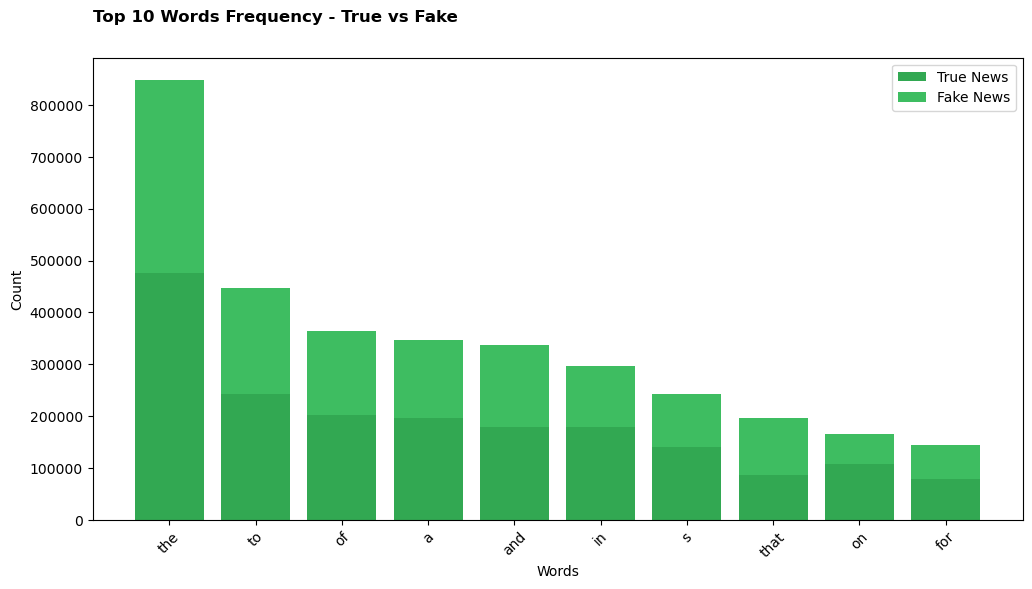

In [147]:
top_words = (fake_freq + true_freq).sort_values(ascending=False).head(10).index

y1 = [true_freq.get(word, 0) for word in top_words]
y2 = [fake_freq.get(word, 0) for word in top_words]

plt.figure(figsize=(12,6))
plt.bar(top_words, y1, label="True News", color="#32a852")
plt.bar(top_words, y2, bottom=y1, label="Fake News", color="#3ebd61")
plt.title("Top 10 Words Frequency - True vs Fake", loc="left", fontdict={"weight": "bold"}, y=1.06)
plt.xlabel("Words")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.legend(loc="upper right")

Text(0.5, 1.0, 'WordCloud - True News')

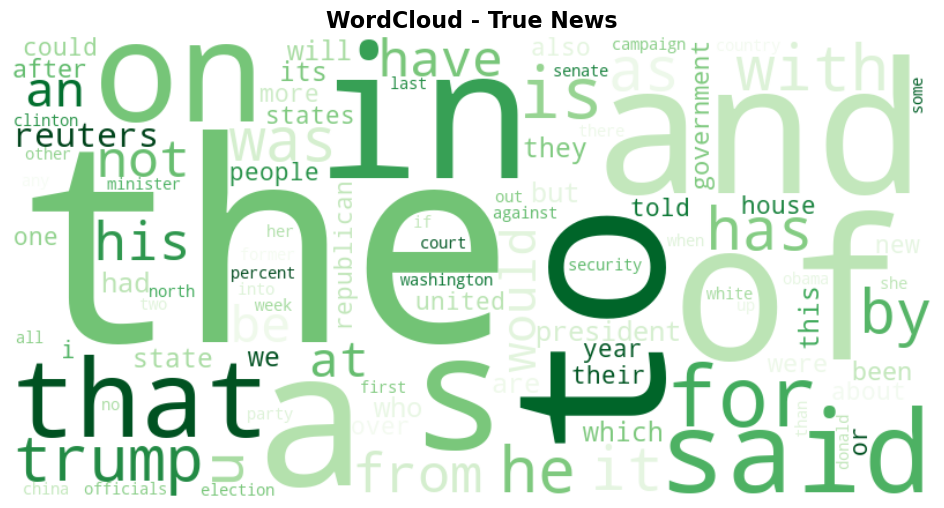

In [148]:
true_freq_dict = true_freq.to_dict()
wc_true = WordCloud(width=800,height=400,background_color="white",colormap="Greens",max_words=100).generate_from_frequencies(true_freq_dict)

plt.figure(figsize=(12,6))
plt.imshow(wc_true, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - True News", fontsize=16, fontweight="bold")

Text(0.5, 1.0, 'WordCloud - Fake News')

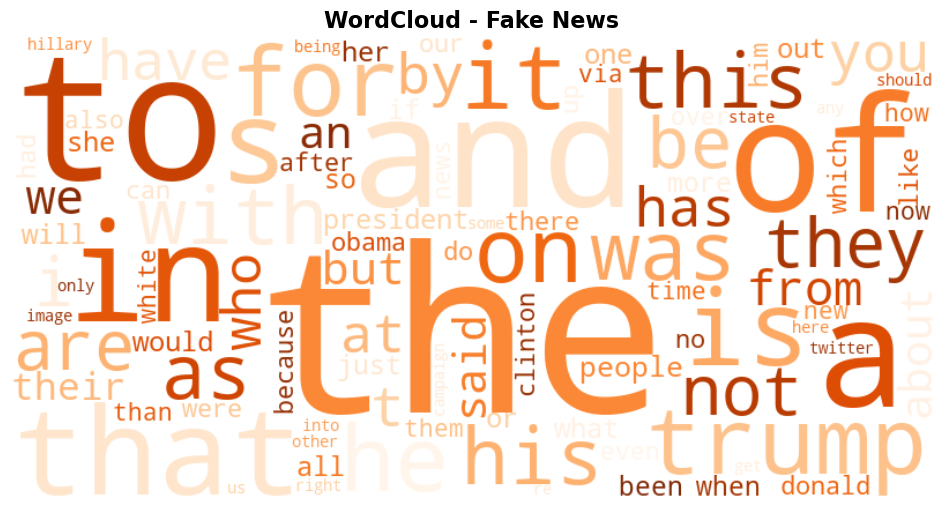

In [149]:
fake_freq_dict = fake_freq.to_dict()
wc_fake = WordCloud(
    width=800,
    height=400,
    background_color="white",
    colormap="Oranges",
    max_words=100).generate_from_frequencies(fake_freq_dict)

plt.figure(figsize=(12,6))
plt.imshow(wc_fake, interpolation="bilinear")
plt.axis("off")
plt.title("WordCloud - Fake News", fontsize=16, fontweight="bold")

# Prepare Data

In [150]:
max_words = 35000
max_len = 150

In [151]:
texts = news['processed'].astype(str)
labels = news['label']

# Tokenization

In [159]:
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

In [161]:
import pickle

with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

In [75]:
sequences = tokenizer.texts_to_sequences(texts)

# Padding

In [77]:
X = pad_sequences(sequences, maxlen=max_len)

In [79]:
y = np.array(labels)

# Train_Test_Split

In [62]:
X_train, X_test, y_train, y_test=train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [63]:
print("Original text:", texts.iloc[0])
print("Tokenized sequence:", sequences[0])
print("Padded sequence:", X[0])

Original text: washington reuters u s senate majority leader mitch mcconnell on wednesday dashed any remaining hopes that president barack obama s signature pacific rim trade deal would come up for a vote before president elect donald trump takes office in january it s certainly not going to be brought up this year mcconnell said of the country trans pacific partnership tpp at a news briefing in washington mcconnell said any decisions on tpp or other future trade agreements would be up to trump who would still have the authority for four more years to negotiate better deals with expedited approval procedures in congress trump excoriated tpp on the campaign trail as a disaster and a rape of our country tapping into populist anger at globalization trade and manufacturing job losses that helped propel his candidacy in an opinion piece published on monday trump advisers peter navarro and alexander gray reiterated his opposition to major trade deals trump will never again sacrifice the u s 

In [64]:
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)
print("y_train distribution:", np.bincount(y_train))
print("y_test distribution:", np.bincount(y_test))

X_train shape: (30004, 150)
X_test shape: (7502, 150)
y_train distribution: [16952 13052]
y_test distribution: [4239 3263]


# RNN

In [87]:
model_rnn = Sequential([Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    SimpleRNN(128, return_sequences=False),
    Dropout(0.3),
    Dense(1, activation='sigmoid')])

model_rnn.build(input_shape=(None, max_len))
model_rnn.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_rnn.summary()

C:\Users\abdo\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ (None, 150, 128)       │     4,480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_1 (SimpleRNN)        │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,513,025 (17.22 MB)

 Trainable params: 4,513,025 (17.22 MB)

 Non-trainable params: 0 (0.00 B)

In [89]:
early_stop = EarlyStopping(monitor='val_loss',patience=3,restore_best_weights=True)
checkpoint = ModelCheckpoint('best_rnn_model.keras',monitor='val_loss',save_best_only=True,verbose=1)

In [91]:
history_rnn = model_rnn.fit(X_train, y_train,epochs=20,batch_size=64,validation_split=0.2,callbacks=[early_stop, checkpoint])

Epoch 1/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 212ms/step - accuracy: 0.8332 - loss: 0.3799
Epoch 1: val_loss improved from None to 0.14093, saving model to best_rnn_model.keras
376/376 ━━━━━━━━━━━━━━━━━━━━ 93s 233ms/step - accuracy: 0.8998 - loss: 0.2634 - val_accuracy: 0.9545 - val_loss: 0.1409
Epoch 2/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step - accuracy: 0.9610 - loss: 0.1156
Epoch 2: val_loss improved from 0.14093 to 0.12385, saving model to best_rnn_model.keras
376/376 ━━━━━━━━━━━━━━━━━━━━ 92s 244ms/step - accuracy: 0.9603 - loss: 0.1156 - val_accuracy: 0.9625 - val_loss: 0.1239
Epoch 3/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 234ms/step - accuracy: 0.9443 - loss: 0.1453
Epoch 3: val_loss did not improve from 0.12385
376/376 ━━━━━━━━━━━━━━━━━━━━ 93s 247ms/step - accuracy: 0.9523 - loss: 0.1291 - val_accuracy: 0.9600 - val_loss: 0.1379
Epoch 4/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.9777 - loss: 0.0656
Epoch 4: val_loss did not improve from 0.12385
376/376 ━━━━━━━━━━━

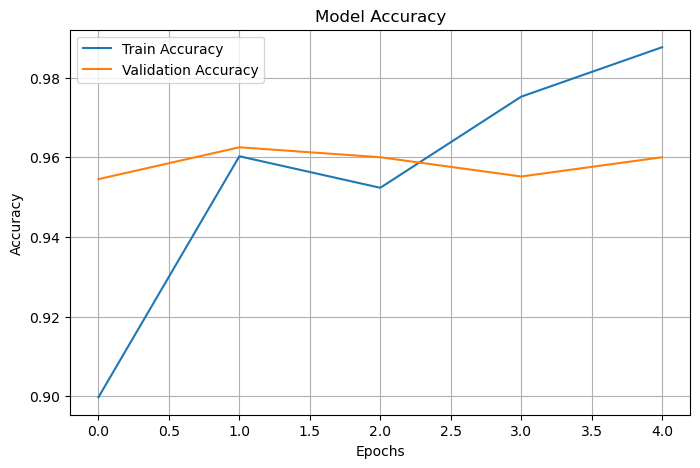

In [95]:
plt.figure(figsize=(8,5))
plt.plot(history_rnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_rnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

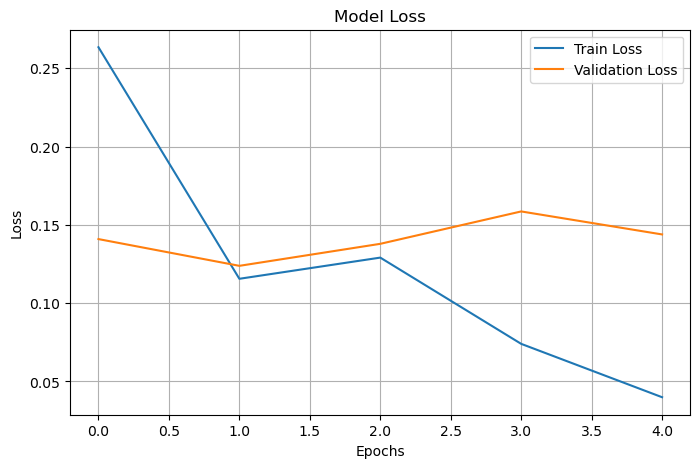

In [97]:
plt.figure(figsize=(8,5))
plt.plot(history_rnn.history['loss'], label='Train Loss')
plt.plot(history_rnn.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# LSTM

In [183]:
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    LSTM(150, return_sequences=True),
    Dropout(0.5),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0001)
model_lstm.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
model_lstm.build(input_shape=(None, max_len))

model_lstm.summary()

C:\Users\abdo\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_12"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_13 (Embedding)        │ (None, 150, 128)       │     4,480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_15 (LSTM)                  │ (None, 150, 150)       │       167,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 150, 150)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_6          │ (None, 150)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 64)             │         9,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,657,129 (17.77 MB)

 Trainable params: 4,657,129 (17.77 MB)

 Non-trainable params: 0 (0.00 B)

In [185]:
model_es = EarlyStopping(monitor='val_loss',mode='min',patience=2,restore_best_weights=True)
model_rlr = ReduceLROnPlateau(monitor='val_loss',factor=0.2,patience=1,mode='min',verbose=1)
model_checkpoint = ModelCheckpoint('best_lstm_model.keras',monitor='val_loss',save_best_only=True,verbose=1)

In [187]:
history_lstm = model_lstm.fit(X_train, y_train,epochs=20,batch_size=64,validation_split=0.2,callbacks=[model_es, model_rlr, model_checkpoint])

Epoch 1/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 807ms/step - accuracy: 0.6767 - loss: 0.5553
Epoch 1: val_loss improved from None to 0.19651, saving model to best_lstm_model.keras
376/376 ━━━━━━━━━━━━━━━━━━━━ 341s 887ms/step - accuracy: 0.8072 - loss: 0.3866 - val_accuracy: 0.9368 - val_loss: 0.1965 - learning_rate: 1.0000e-04
Epoch 2/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 799ms/step - accuracy: 0.9620 - loss: 0.1233
Epoch 2: val_loss improved from 0.19651 to 0.17573, saving model to best_lstm_model.keras
376/376 ━━━━━━━━━━━━━━━━━━━━ 376s 872ms/step - accuracy: 0.9639 - loss: 0.1156 - val_accuracy: 0.9522 - val_loss: 0.1757 - learning_rate: 1.0000e-04
Epoch 3/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 857ms/step - accuracy: 0.9834 - loss: 0.0651
Epoch 3: val_loss improved from 0.17573 to 0.11324, saving model to best_lstm_model.keras
376/376 ━━━━━━━━━━━━━━━━━━━━ 419s 969ms/step - accuracy: 0.9838 - loss: 0.0614 - val_accuracy: 0.9632 - val_loss: 0.1132 - learning_rate: 1.0000e-04
Epoch 4/20
376/376 ━━━

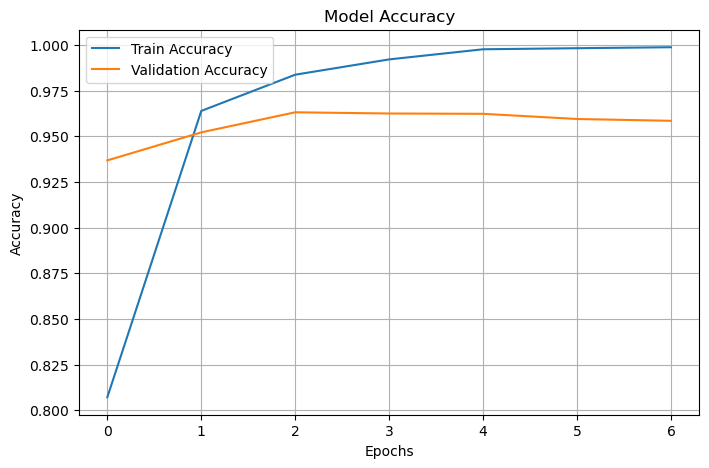

In [190]:
plt.figure(figsize=(8,5))
plt.plot(history_lstm.history['accuracy'], label='Train Accuracy')
plt.plot(history_lstm.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

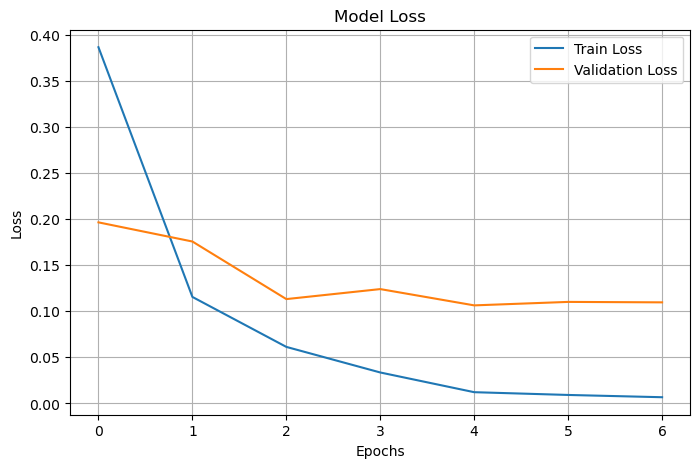

In [192]:
plt.figure(figsize=(8,5))
plt.plot(history_lstm.history['loss'], label='Train Loss')
plt.plot(history_lstm.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# GRU

In [220]:
model_gru = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_len),
    GRU(128, return_sequences=False),
    Dropout(0.4),
    Dense(1, activation='sigmoid')
])

model_gru.build(input_shape=(None, max_len))
model_gru.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model_gru.summary()

C:\Users\abdo\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_18 (Embedding)        │ (None, 150, 128)       │     4,480,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 128)            │        99,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_27 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_27 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,579,201 (17.47 MB)

 Trainable params: 4,579,201 (17.47 MB)

 Non-trainable params: 0 (0.00 B)

In [222]:
model_es = EarlyStopping(monitor='val_accuracy',mode='max',patience=2,restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_gru_model.keras',monitor='val_accuracy',save_best_only=True,mode='max',verbose=1)

In [224]:
history_gru = model_gru.fit(X_train, y_train,epochs=20,batch_size=64,validation_split=0.2,callbacks=[model_es,model_checkpoint])

Epoch 1/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 615ms/step - accuracy: 0.8927 - loss: 0.2495
Epoch 1: val_accuracy improved from None to 0.97284, saving model to best_gru_model.keras
376/376 ━━━━━━━━━━━━━━━━━━━━ 262s 677ms/step - accuracy: 0.9464 - loss: 0.1435 - val_accuracy: 0.9728 - val_loss: 0.0887
Epoch 2/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 621ms/step - accuracy: 0.9789 - loss: 0.0676
Epoch 2: val_accuracy did not improve from 0.97284
376/376 ━━━━━━━━━━━━━━━━━━━━ 251s 667ms/step - accuracy: 0.9728 - loss: 0.0822 - val_accuracy: 0.9708 - val_loss: 0.0882
Epoch 3/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 625ms/step - accuracy: 0.9912 - loss: 0.0255
Epoch 3: val_accuracy improved from 0.97284 to 0.97617, saving model to best_gru_model.keras
376/376 ━━━━━━━━━━━━━━━━━━━━ 265s 675ms/step - accuracy: 0.9916 - loss: 0.0250 - val_accuracy: 0.9762 - val_loss: 0.0790
Epoch 4/20
376/376 ━━━━━━━━━━━━━━━━━━━━ 0s 629ms/step - accuracy: 0.9977 - loss: 0.0090
Epoch 4: val_accuracy did not improve from 0.97617


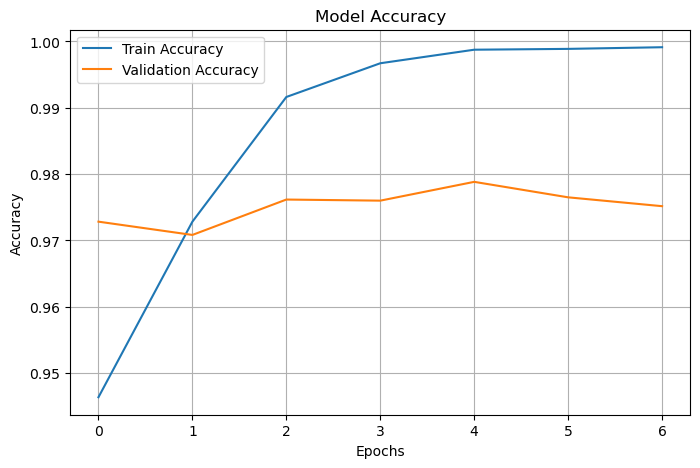

In [226]:
plt.figure(figsize=(8,5))
plt.plot(history_gru.history['accuracy'], label='Train Accuracy')
plt.plot(history_gru.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

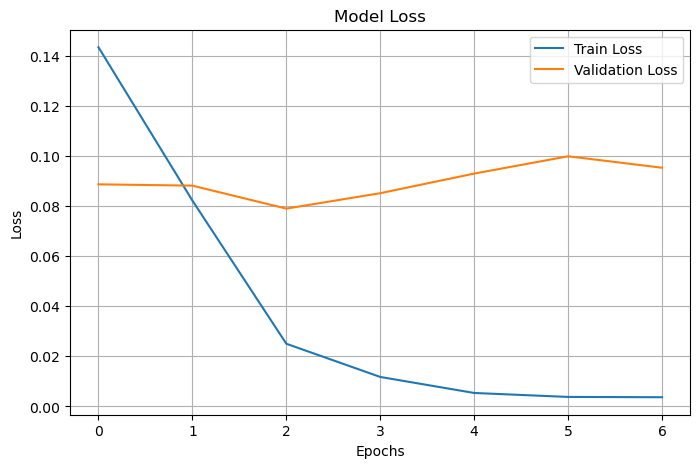

In [228]:
plt.figure(figsize=(8,5))
plt.plot(history_gru.history['loss'], label='Train Loss')
plt.plot(history_gru.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Comparison

In [230]:
print("RNN Test Accuracy:", model_rnn.evaluate(X_test, y_test, verbose=0)[1])
print("LSTM Test Accuracy:", model_lstm.evaluate(X_test, y_test, verbose=0)[1])
print("GRU Test Accuracy:", model_gru.evaluate(X_test, y_test, verbose=0)[1])

RNN Test Accuracy: 0.9629431962966919
LSTM Test Accuracy: 0.9652093052864075
GRU Test Accuracy: 0.9816049337387085


# Roc Curve

235/235 ━━━━━━━━━━━━━━━━━━━━ 8s 33ms/step

Confusion Matrix for RNN:
[[4186   53]
 [ 225 3038]]
235/235 ━━━━━━━━━━━━━━━━━━━━ 25s 105ms/step

Confusion Matrix for GRU:
[[4174   65]
 [  73 3190]]
235/235 ━━━━━━━━━━━━━━━━━━━━ 41s 170ms/step

Confusion Matrix for LSTM:
[[4077  162]
 [  99 3164]]


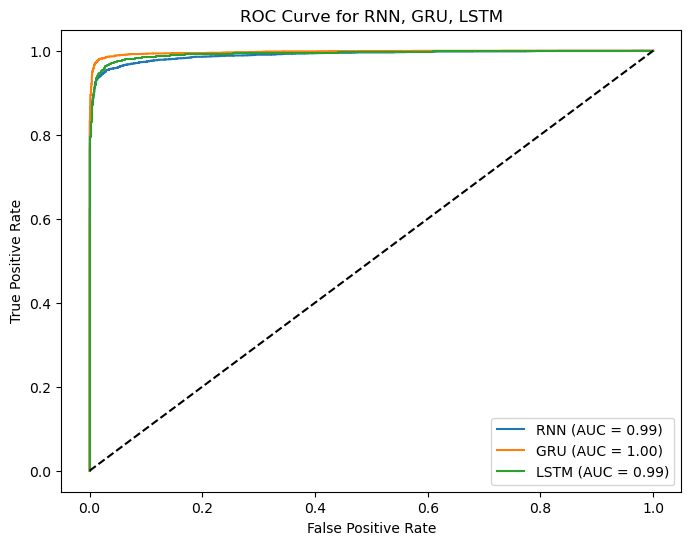

In [237]:
models = {
    'RNN': model_rnn,
    'GRU': model_gru,
    'LSTM': model_lstm
}

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_pred_prob = model.predict(X_test).ravel()
    
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    roc_auc = auc(fpr, tpr)
    
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')
    
    y_pred_class = (y_pred_prob > 0.5).astype(int)
    cm = confusion_matrix(y_test, y_pred_class)
    print(f"\nConfusion Matrix for {name}:\n{cm}")

plt.plot([0,1], [0,1], 'k--')
plt.title("ROC Curve for RNN, GRU, LSTM")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc="lower right")

# GRU with GloVe

In [81]:
embedding_dim=50 # i chose 50 because the file is 50d vector
embedding_index = {}

In [89]:
with open(r"E:\NLP\glove.12B.txt", encoding="utf8") as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector_values = values[1:]
        if len(vector_values) != 50:
            continue
        try:
            vector = np.asarray(vector_values, dtype="float32")
            embedding_index[word] = vector
        except ValueError:
            continue

In [95]:
first_word = next(iter(embedding_index))
print("First word:", first_word)
print("Vector:", embedding_index[first_word])

First word: the
Vector: [-3.833960e-01 -4.806740e-01 -2.741410e-01  1.326970e-01  6.488500e-02
 -9.248900e-02 -2.991000e-03  1.689180e-01  4.276900e-01  3.206200e-02
  6.006520e-01  4.555000e-03  2.215680e-01 -1.068170e-01  3.399550e-01
 -2.481650e-01 -6.553400e-02  1.650310e-01 -9.891500e-02 -2.670600e-01
 -3.516120e-01 -5.958360e-01 -7.483280e-01 -2.621910e-01 -4.001830e-01
  3.064770e-01  1.324700e-01  1.495320e-01 -4.629820e-01  4.364060e-01
 -3.284060e-01 -1.122970e-01 -3.181580e-01 -5.861770e-01 -2.417460e-01
 -3.828590e-01 -4.337860e-01  5.955205e+00  1.372390e-01 -6.451600e-02
  4.565220e-01 -1.923900e-02  2.606240e-01 -2.935770e-01  1.989750e-01
  2.776530e-01  1.645520e-01  4.064900e-01 -2.279070e-01 -4.003160e-01]


In [91]:
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))

In [97]:
vocab_size

108768

In [93]:
for word, i in tokenizer.word_index.items():
    if i < max_words:
        embedding_vector = embedding_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector

In [99]:
model = Sequential([Embedding(input_dim=vocab_size,output_dim=embedding_dim,weights=[embedding_matrix],input_length=max_len,
              trainable=True), 
    GRU(128, return_sequences=False),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.build(input_shape=(None, max_len))
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])
model.summary()

C:\Users\abdo\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 150, 50)        │     5,438,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 128)            │        69,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,507,649 (21.01 MB)

 Trainable params: 5,507,649 (21.01 MB)

 Non-trainable params: 0 (0.00 B)

In [105]:
early_stop = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
checkpoint = ModelCheckpoint('best_Glove_model.keras', monitor='val_loss', save_best_only=True, verbose=1)

In [107]:
history = model.fit(X, y,epochs=20,batch_size=32,validation_split=0.2,callbacks=[early_stop, checkpoint])

Epoch 1/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 350ms/step - accuracy: 0.9131 - loss: 0.2087
Epoch 1: val_loss improved from None to 0.04925, saving model to best_Glove_model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 353s 374ms/step - accuracy: 0.9526 - loss: 0.1265 - val_accuracy: 0.9819 - val_loss: 0.0493
Epoch 2/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 331ms/step - accuracy: 0.9850 - loss: 0.0468
Epoch 2: val_loss improved from 0.04925 to 0.03956, saving model to best_Glove_model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 363s 354ms/step - accuracy: 0.9847 - loss: 0.0474 - val_accuracy: 0.9865 - val_loss: 0.0396
Epoch 3/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 344ms/step - accuracy: 0.9925 - loss: 0.0251
Epoch 3: val_loss improved from 0.03956 to 0.03628, saving model to best_Glove_model.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 345s 368ms/step - accuracy: 0.9924 - loss: 0.0247 - val_accuracy: 0.9873 - val_loss: 0.0363
Epoch 4/20
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step - accuracy: 0.9969 - loss: 0.0104
Epoch 4: val_lo